In [150]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import pickle
from scipy.linalg import hankel
from scipy.stats import dirichlet
from scipy.special import factorial, logsumexp
import statsmodels.api as sm
import matplotx
from multiprocessing import Pool

plt.style.use(matplotx.styles.aura["dark"])

In [2]:
def trial_xticks(ax, xlocs, yloc=-0.04):
    xlocs = np.array(xlocs)
    ax.set_xticks(xlocs)
    ax.set_xticklabels([])
    ax.tick_params("x", length=17, width=1, which="major")
    ax.set_xlabel("Time", labelpad=10)

    periods = ["S", "Cue", "Delay", "Arm", "Reward"]
    for i in range(5):
        xloc = xlocs[i] + (xlocs[i + 1] - xlocs[i]) / 2
        ax.text(
            xloc,
            yloc,
            periods[i],
            fontsize=10,
            horizontalalignment="center",
            verticalalignment="top",
            transform=ax.get_xaxis_transform(),
            rotation=0,
        )


def nll(w, X, y):
    lam = np.exp(X @ w)
    # print(lam.shape)
    return -1 * y.T @ np.log(lam) + lam.sum() - 0.5 * w.T @ w


colors = ["tab:red", "tab:blue"]

In [3]:
with open("test_data_acc_ind_492_0607.pickle", "rb") as handle:
    data = pickle.load(handle)
print(data.keys())
total_neurons = len(data["spikes"])
print(f"n_neurons: {total_neurons}")
print("n_trials: {}".format(data["choice"].size))

dict_keys(['nCues_RminusL', 'currMaze', 'laserON', 'trialStart', 'trialEnd', 'keyFrames', 'time', 'cueOnset_L', 'cueOnset_R', 'choice', 'trialType', 'spikes', 'timeSqueezedFR'])
n_neurons: 324
n_trials: 290


In [4]:
# constructing design matrix with all trials and all neurons
np.random.seed(0)
X_all = []
y_all = []
trial_indices = np.nonzero(data["currMaze"] > 0)[0]
print(f"number of trials: {trial_indices.size}")
filt_len = 30
bin_size = 0.35
n_neurons = 50
neuron_idx = np.random.randint(0, total_neurons, size=n_neurons)
trial_id = []
X = []


for trial_idx in trial_indices:
    trial_start = data["trialStart"][trial_idx]
    trial_end = data["trialEnd"][trial_idx]
    trial_length = trial_end - trial_start

    keyframes = data["keyFrames"][trial_idx]
    keyframe_times = data["time"][trial_idx][keyframes.astype(int)].tolist()
    lcue_times = data["cueOnset_L"][trial_idx]
    rcue_times = data["cueOnset_R"][trial_idx]

    bins = np.arange(0, trial_length, bin_size)
    bin_centers = np.convolve(bins, [0.5, 0.5], mode="valid")

    binned_stimr, _ = np.histogram(rcue_times, bins)
    binned_stiml, _ = np.histogram(lcue_times, bins)
    binned_ev = np.cumsum(binned_stimr) - np.cumsum(binned_stiml)

    padded_stimr = np.pad(binned_stimr, (filt_len - 1, 0), constant_values=(0, 0))
    X_sr = hankel(padded_stimr[: -filt_len + 1], padded_stimr[-filt_len:])
    padded_stiml = np.pad(binned_stiml, (filt_len - 1, 0), constant_values=(0, 0))
    X_sl = hankel(padded_stiml[: -filt_len + 1], padded_stiml[-filt_len:])
    padded_ev = np.pad(binned_ev, (filt_len - 1, 0), constant_values=(0, 0))
    X_ev = hankel(padded_ev[: -filt_len + 1], padded_stiml[-filt_len:])

   

    X.append(np.hstack((X_sr, X_sl, np.ones((X_sr.shape[0], 1)))))
    trial_id.append(trial_idx * np.ones(X_sr.shape[0]))


trial_id = np.concatenate(trial_id).astype(int)
X = np.vstack(X)
print(f'X shape = {X.shape}')


number of trials: 290
X shape = (13238, 61)


transition matrix: 
[[0.77 0.09 0.14]
 [0.37 0.44 0.2 ]
 [0.07 0.   0.93]]


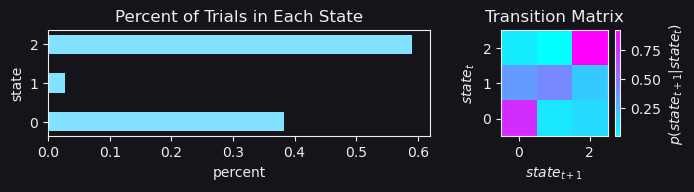

In [5]:
# Generating states for simulation
np.random.seed(0)
n_states = 3
t_init = np.array([1.3, 0.7, 0.7])
T = np.array([dirichlet(np.roll(t_init**(n+1), n)).rvs()[0] for n in range(n_states)])
dist_init = np.array([0.8, 0.1, 0.1])
sim_states = np.ones(trial_indices.size).astype(int)
for i in range(sim_states.size):
    if i == 0:
        sim_states[i] = np.random.choice(np.arange(n_states), 1, p=dist_init)
    sim_states[i] = np.random.choice(np.arange(n_states), 1, p=T[sim_states[i-1]])

print(f'transition matrix: \n{np.round(T, 2)}')
fig, axs = plt.subplots(1, 2, figsize=(7, 2), gridspec_kw={'width_ratios': [5, 2]})
_ = axs[0].hist(sim_states, bins=np.arange(-0.5, 2.51, 1), density=True, rwidth=0.5, orientation='horizontal')
axs[0].set_title('Percent of Trials in Each State')
axs[0].set_xlabel('percent')
axs[0].set_ylabel('state')
im = axs[1].imshow(T, cmap='cool', origin='lower')
plt.colorbar(im, ax=axs[1], label='$p(state_{t+1} | state_t)$')
axs[1].set_title('Transition Matrix')
axs[1].set_ylabel(r'$state_t$')
axs[1].set_xlabel(r'$state_{t+1}$')
plt.tight_layout()

In [6]:
# generating parameters for each state for each neuron
n_filters = 2
theta_sim = np.empty((n_states, filt_len*n_filters+1, n_neurons))
for n in range(n_neurons):
    for s in range(n_states):
        for f in range(n_filters):  # 2 filters, right stim, left stim, (no spikes for simulated data)
            for i in range(filt_len):
                if i == 0:
                    theta_sim[s, i+(f * filt_len), n] = np.random.normal(0, 0.1)
                else:
                    theta_sim[s, i+(f*filt_len), n] = np.random.normal(theta_sim[s, i+(f*filt_len)-1, n], .02)
        theta_sim[s, -1, n] = np.random.normal(0.15, 0.05) #bias term

print(theta_sim.shape)

(3, 61, 50)


In [7]:
# generating spike rate data
y_sim = []
for trial in np.unique(trial_id):
    x_idx = np.argwhere(trial_id==trial)
    y_sim.append(np.squeeze(X[x_idx] @ theta_sim[sim_states[trial]]))

y_sim = np.exp(np.vstack(y_sim))
print(y_sim.shape)

(13238, 50)


In [10]:
#initial glm with no states to estimate weights
theta_init = np.empty(theta_sim[0].shape)
sta = (X.T @ y_sim) / y_sim.sum()
for neuron in range(n_neurons):
    glm = sm.GLM(endog=y_sim[:, neuron], exog=X, family=sm.families.Poisson())

    a = 1 * np.ones(X.shape[1])
    a[-1] = 0
    res = glm.fit_regularized(start_params=sta[:, neuron], alpha=a, L1_wt=0.0, maxiter=1000, cnvrg_tol=1e-6)

    w = res.params
    theta_init[:, neuron] = w

In [198]:
np.random.seed(0)
n_states = 3
n_trials = trial_indices.size
theta_hmm = np.ones((n_states, X.shape[1], n_neurons)) * theta_init
# adding noise to all the weights
theta_hmm += np.random.normal(0, 0.2, size=theta_hmm.shape)
# theta_hmm = theta_sim
t_init = np.array([5, 1, 1])
# placing higher bias on self-transition
T = np.array([dirichlet(np.roll(t_init, n)).rvs()[0] for n in range(n_states)])
pi = np.ones(n_states) / n_states
alpha = np.empty((n_states, n_trials))
beta = np.empty(alpha.shape)
beta[:, -1] = 1
predict = np.empty(alpha.shape)
loglikeli = np.empty(alpha.shape)
xi = np.empty((n_trials-1, n_states, n_states))

def log_space_product(A,B):
    Astack = np.stack([A]*B.shape[1]).transpose(1,0,2)
    Bstack = np.stack([B]*A.shape[0]).transpose(0,2,1)
    return logsumexp(Astack+Bstack, axis=2)


def lognormalize(x):
    a = np.logaddexp.reduce(x)
    return np.exp(x - a)

# expectation step:
for t in range(0, n_trials):
    x_idx = np.argwhere(trial_id==t).squeeze()


    # predict
    if t == 0:
        predict[:, t] = pi
    else:
        predict[:, t] = T.T @ alpha[:, t-1]

    lam = np.exp(X[x_idx] @ theta_hmm)
    ll = (np.log(lam).transpose(2, 0, 1) @ y_sim[x_idx].T[:, :, None]).squeeze()  - lam.sum(axis=1).T - np.log(factorial(y_sim[x_idx])).sum(axis=0)[:, None]
    ll -= logsumexp(ll, axis=1)[:, None]
    if np.any(np.isnan(ll)):  # not sure how else to deal with overflows but this probably is not it
        nan_idx = np.nonzero(np.isnan(ll))[0]
        ll[nan_idx] = 1/n_states

    loglikeli[:, t] = ll.sum(axis=0)
    # likeli = (lam ** y_sim[x_idx] * np.exp(-lam))/factorial(y_sim[x_idx])
    # loglikeli = np.log(likeli).sum(axis=(1,2))
    # update
    update = loglikeli[:, t] + np.log(predict[:, t])
    update = lognormalize(update)
    alpha[:, t] = update
    # print(alpha[:, t])

for t in range(n_trials-1, 0, -1):
    beta_update = log_space_product(np.log(T), (np.log(beta[:, t]) + loglikeli[:, t])[:, None]).squeeze()
    # print(beta_update, loglikeli[:, t], lognormalize(beta_update), '\n\n')
    beta[:, t-1] = lognormalize(beta_update)

gamma = alpha * beta

loglikeli -= logsumexp(loglikeli, axis=0)
likeli = np.exp(loglikeli)
for t in range(0, n_trials-1):
    xi[t, :, :] = T * (alpha[:, t].reshape(-1, 1) @ (likeli[:, t+1] * beta[:, t+1]).reshape(1, -1))

T = xi.sum(axis=0) / xi.sum(axis=0).sum(axis=1)  # updating transition matrix

# maximization
for s in range(n_states):
    for neuron in range(n_neurons):
        glm = sm.GLM(endog=y_sim[:, neuron], exog=X, family=sm.families.Poisson())

        a = 1 * np.ones(X.shape[1])
        a[-1] = 0
        res = glm.fit_regularized(start_params=sta[:, neuron], alpha=a, L1_wt=0.0, maxiter=1000, cnvrg_tol=1e-6)

        w = res.params
        theta_init[:, neuron] = w

/tmp/ipykernel_128770/497256643.py:42: RuntimeWarning: invalid value encountered in subtract
  ll -= logsumexp(ll, axis=1)[:, None]


array([[0.9519889 , 0.18637679, 0.37475322],
       [0.04338197, 0.43595982, 0.00553763],
       [0.01367846, 0.0125628 , 0.83611335]])

### actual data

In [ ]:
# constructing design matrix with all trials and all neurons
np.random.seed(0)
X_all = []
y_all = []
trial_indices = np.nonzero(data["currMaze"] > 0)[0]
print(f"number of trials: {trial_indices.size}")
filt_len = 30
bin_size = 0.35
n_neurons = 50
neuron_idx = np.random.randint(0, total_neurons, size=n_neurons)

trial_id = []  # this will keep track of each trial in the design matrix (since each trial spans multiple rows)
for i, neuron in enumerate(neuron_idx):
    X = []
    y = []

    for trial_idx in trial_indices:
        trial_start = data["trialStart"][trial_idx]
        trial_end = data["trialEnd"][trial_idx]
        trial_length = trial_end - trial_start
        spikes = data["spikes"][neuron]
        spikes = spikes[(spikes > trial_start) * (spikes < trial_end)]
        keyframes = data["keyFrames"][trial_idx]
        keyframe_times = data["time"][trial_idx][keyframes.astype(int)].tolist()
        lcue_times = data["cueOnset_L"][trial_idx]
        rcue_times = data["cueOnset_R"][trial_idx]

        bins = np.arange(0, trial_length, bin_size)
        bin_centers = np.convolve(bins, [0.5, 0.5], mode="valid")

        binned_stimr, _ = np.histogram(rcue_times, bins)
        binned_stiml, _ = np.histogram(lcue_times, bins)
        binned_spikes, _ = np.histogram(spikes - trial_start, bins)
        binned_ev = np.cumsum(binned_stimr) - np.cumsum(binned_stiml)

        padded_stimr = np.pad(binned_stimr, (filt_len - 1, 0), constant_values=(0, 0))
        X_sr = hankel(padded_stimr[: -filt_len + 1], padded_stimr[-filt_len:])
        padded_stiml = np.pad(binned_stiml, (filt_len - 1, 0), constant_values=(0, 0))
        X_sl = hankel(padded_stiml[: -filt_len + 1], padded_stiml[-filt_len:])
        padded_ev = np.pad(binned_ev, (filt_len - 1, 0), constant_values=(0, 0))
        X_ev = hankel(padded_ev[: -filt_len + 1], padded_stiml[-filt_len:])

        padded_spikes = np.pad(
            binned_spikes[:-1], (filt_len, 0), constant_values=(0, 0)
        )
        X_sp = hankel(padded_spikes[: -filt_len + 1], padded_spikes[-filt_len:])

        X.append(np.hstack((X_sr, X_sl, X_sp, np.ones((X_sp.shape[0], 1)))))
        y.append(binned_spikes[:, np.newaxis])
        if i == 0:
            trial_id.append(trial_idx * np.ones(X_sr.shape[0]))

    X_all.append(np.vstack(X))
    y_all.append(np.vstack(y))

trial_id = np.concatenate(trial_id)
X_all = np.array(X_all)
y_all = np.array(y_all)

In [ ]:
# def glm_fit(d):
#     x, y = d
#     glm = sm.GLM(endog=y, exog=x, family=sm.families.Poisson())

#     res = glm.fit(max_iter=1000, tol=1e-6, tol_criterion="params")
#     return res.params

# input = tuple(zip(X_all, y_all))

# pool = Pool(10)

# w_initial = pool.map(glm_fit, input)